In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [2]:
!pip install -Uqq duckduckgo_search
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 17.7 MB/s eta 0:00:00


## Test single images

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastbook import *

In [4]:
def search_images(term, max=30):
  print(f"Searching for '{term}'")
  # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
  return search_images_ddg(term, max_images=max)

Searching for 'mushroom photos'


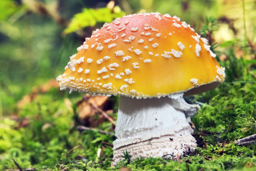

In [5]:
urls = search_images("mushroom photos")
dest = 'mushroom.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'new york night photos'


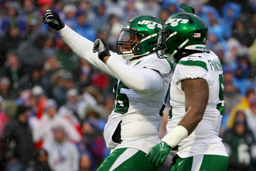

In [6]:
nyc_urls = search_images("new york night photos")
nyc_dest = 'nyc.jpg'
download_url(nyc_urls[0], nyc_dest, show_progress=False)
im = Image.open(nyc_dest)
im.to_thumb(256,256)

## Batch download

In [7]:
searches = "mushroom","new york"
path = Path('mushroom_or_not')
from time import sleep

for item in searches:
    dest = (path/item)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{item} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{item} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{item} shade photo'))
    sleep(10)
    resize_images(path/item, max_size=400, dest=path/item) 

Searching for 'mushroom photo'
Searching for 'mushroom sun photo'
Searching for 'mushroom shade photo'
Searching for 'new york photo'
Searching for 'new york sun photo'
Searching for 'new york shade photo'


## Train the model

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

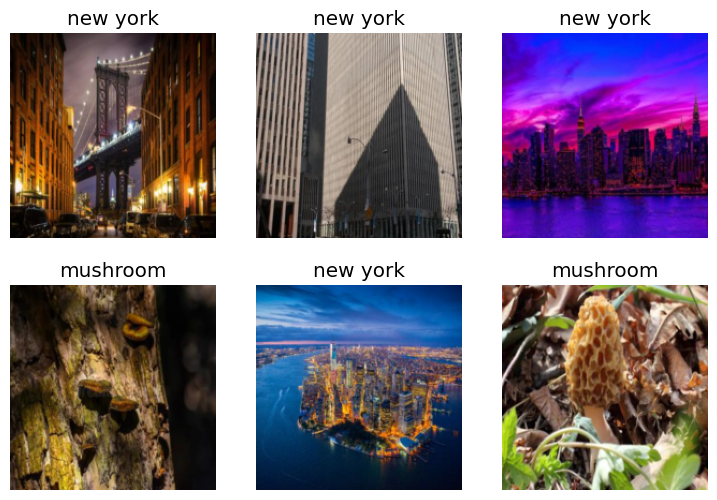

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # inputs to our model are images, and the outputs are categories
    get_items=get_image_files, # find all the inputs to our model, which returns a list of all image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    get_y=parent_label, # the labels will be the parent of each file, in this case the folder they are in, new york, or mushroom
    item_tfms=[Resize(192, method='squish')] #resize each image to 192x192 pixels by "squishing" it
).dataloaders(path)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


## Prediction

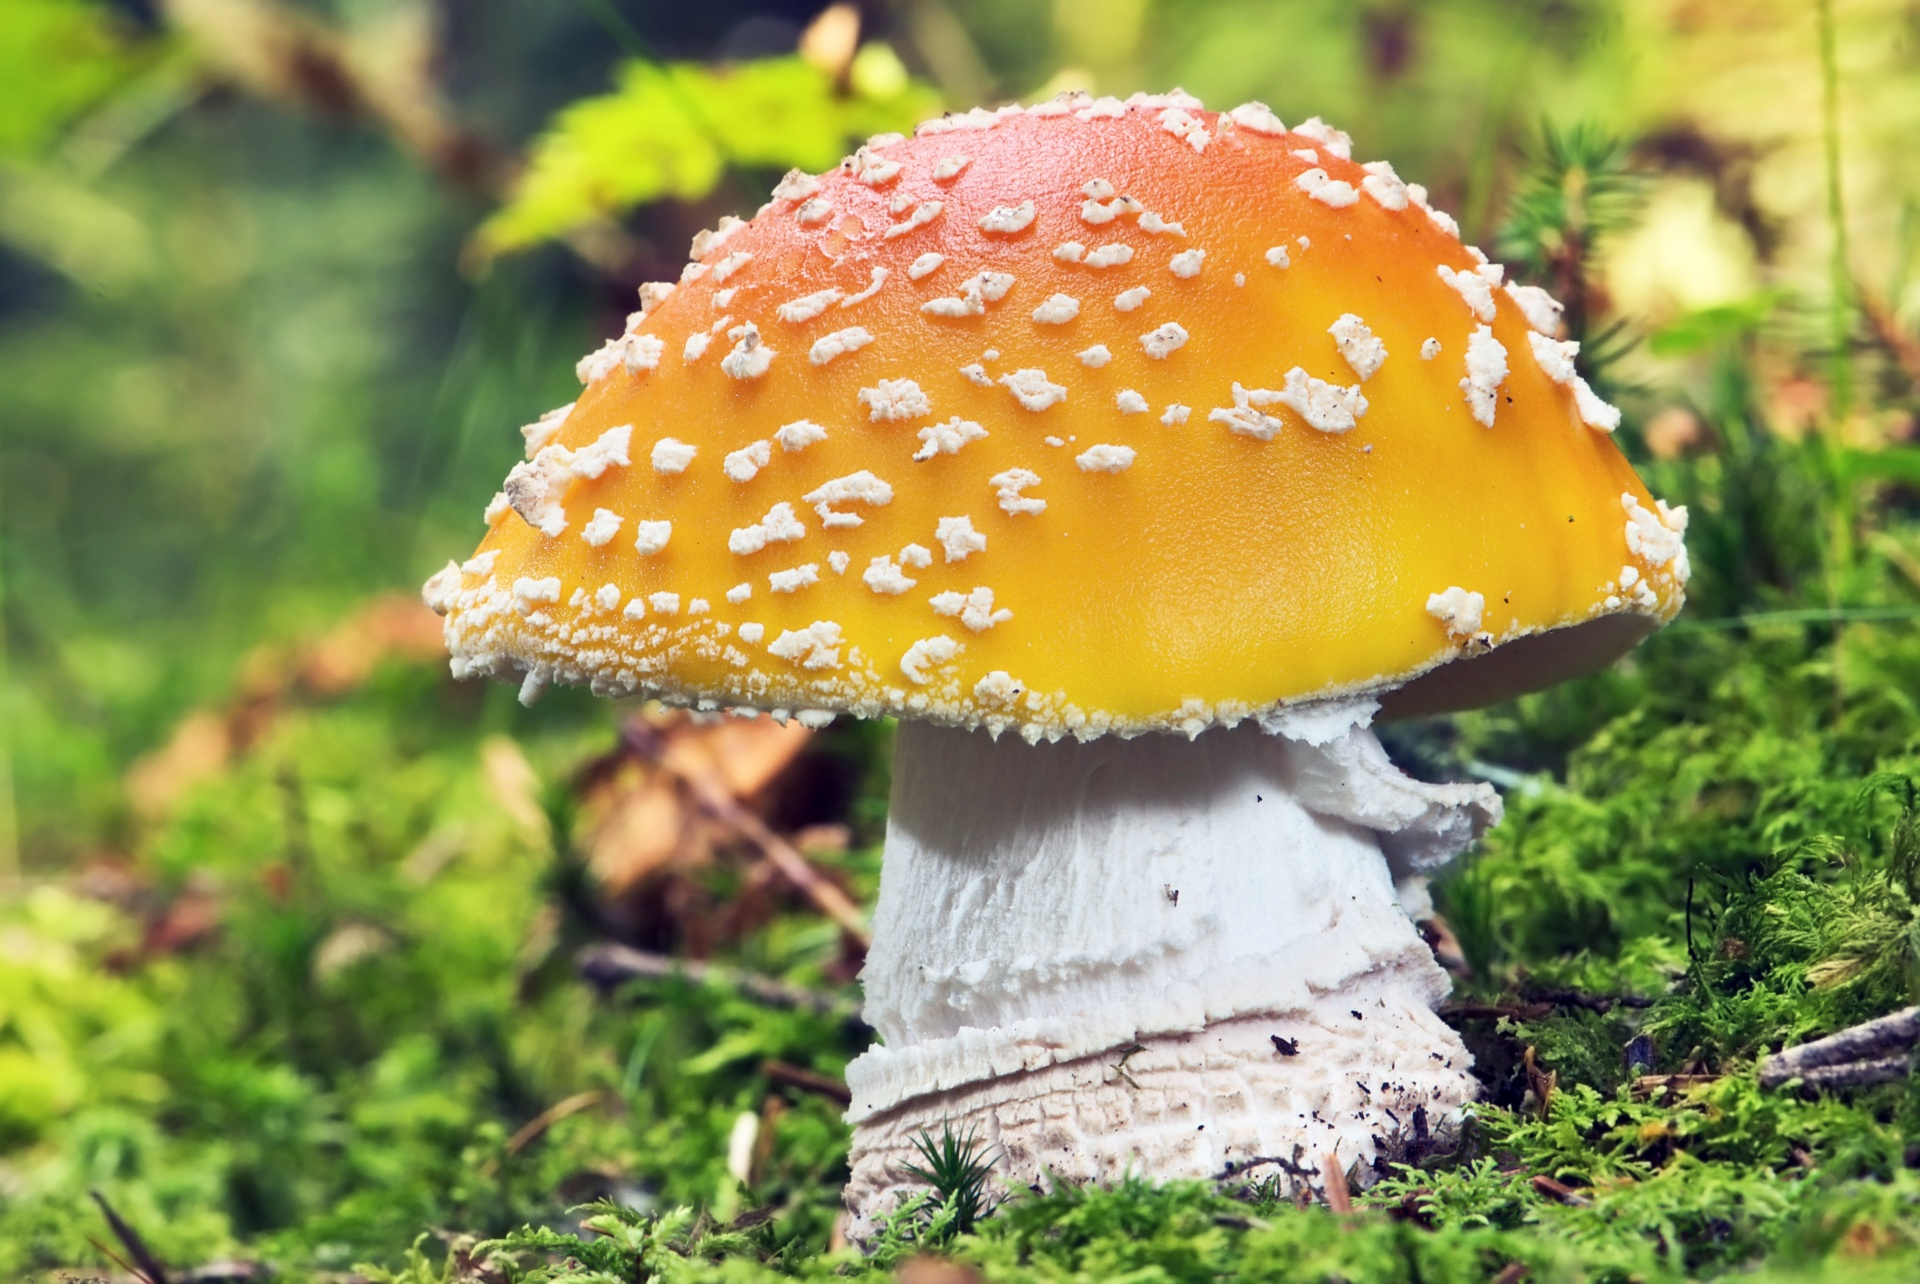

In [11]:
mushroom = PILImage.create('mushroom.jpg')
mushroom 

In [12]:
is_mushroom,_,probs = learn.predict(mushroom)
print(f"This is a: {is_mushroom}.")
print(f"Probability it's a mushroom: {probs[0]:.4f}")

This is a: mushroom.
Probability it's a mushroom: 0.9991
